# Dependencies

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW, lr_scheduler
import torchvision.transforms as T
from torchvision import datasets, ops
from torchvision.models.feature_extraction import create_feature_extractor
from einops import rearrange

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import linear_sum_assignment

Noteworthy points for our data preparation are:

1. All images are resized to (480, 480); this is an arbitrary decision to facilitate this didactic work. The original work applied independent resizing for each sample, varying between 480 and 1333.
2. The target labels are the 4 box coordinates and the box class. The box coordinates are their centers (cx, cy) and their dimensions (w, h). The box classes are the original 6 classes, plus the "empty" class.
3. The bounding box coordinates are all normalized to represent a relative size with regard to the image input, thus, their values will be in the range [0, 1].

Now, we declare all methods required to handle the dataset.

In [2]:
CLASSES = [
    'N/A', 'glove', 'infusion', 'mask', 'spuit', 'syringe', 'vial'
]

# Colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], 
          [0.929, 0.694, 0.125], [0.494, 0.184, 0.556],
          [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
COLORS *= 100

revert_normalization = T.Normalize(
    mean=[-.485/.229, -.456/.224, -.406/.225],
    std=[1/.229, 1/.224, 1/.225]
)

def plot_im_with_boxes(im, boxes, probs=None, ax=None):
    
    if ax is None:
        plt.imshow(im)
        ax = plt.gca()
        
    for i, b in enumerate(boxes.tolist()):
        xmin, ymin, xmax, ymax = b
        
        patch = plt.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin,
            fill=False, color=COLORS[i], linewidth=2)
        
        ax.add_patch(patch)
        if probs is not None:
            if probs.ndim == 1:
                cl = probs[i].item()
                text = f'{CLASSES[cl]}'
            else:
                cl = probs[i].argmax().item()
                text = f'{CLASSES[cl]}: {probs[i,cl]:0.2f}'
        else:
            text = ''
            
        ax.text(xmin, ymin, text, fontsize=7,
                bbox=dict(facecolor='yellow', alpha=0.5))
    
    
def preprocess_target(anno, im_w, im_h):
    
    anno = [obj for obj in anno 
            if 'iscrowd' not in obj or obj['iscrowd'] == 0]

    boxes = [obj["bbox"] for obj in anno]
    boxes = torch.as_tensor(
        boxes, dtype=torch.float32).reshape(-1, 4)
    
    # xywh -> xyxy
    boxes[:, 2:] += boxes[:, :2]
    boxes[:, 0::2].clamp_(min=0, max=im_w)
    boxes[:, 1::2].clamp_(min=0, max=im_h)
    keep = (boxes[:, 3] > boxes[:, 1]) & (boxes[:, 2] > boxes[:, 0])
    boxes = boxes[keep]

    classes = [obj["category_id"] for obj in anno]
    classes = torch.tensor(classes, dtype=torch.int64)
    classes = classes[keep]

    # scales boxes to [0,1]
    boxes[:, 0::2] /= im_w
    boxes[:, 1::2] /= im_h
    boxes.clamp_(min=0, max=1)

    boxes = ops.box_convert(boxes, in_fmt='xyxy', out_fmt='cxcywh')
    return classes, boxes

class MyCocoDetection(datasets.CocoDetection):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.edge = 480

        self.T = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[.485, .456, .406],
                        std=[.229, .224, .225]),
            T.Resize((self.edge, self.edge), antialias=True)
        ])

        self.T_target = preprocess_target

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        # PIL image
        w, h = img.size

        input_ = self.T(img)
        classes, boxes = self.T_target(target, w, h)

        return input_, (classes, boxes)

def collate_fn(inputs):
    input_ = torch.stack([i[0] for i in inputs])
    classes = tuple([i[1][0] for i in inputs])
    boxes = tuple([i[1][1] for i in inputs])
    return input_, (classes, boxes)

Then, we import the tiny set.

In [3]:
train_ds = MyCocoDetection(
    root='medical_image.v2i.coco/train/',
    annFile='medical_image.v2i.coco/train/_annotations.coco.json',
)

valid_ds = MyCocoDetection(
    root='medical_image.v2i.coco/valid/', 
    annFile='medical_image.v2i.coco/valid/_annotations.coco.json'
)

test_ds = MyCocoDetection(
    root='medical_image.v2i.coco/test/', 
    annFile='medical_image.v2i.coco/test/_annotations.coco.json'
)


train_loader = DataLoader(
    train_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)

print(f'\nNumber of training samples: {len(train_ds)}')

print(f'Number of validation samples: {len(valid_ds)}')
print(f'Number of test samples: {len(test_ds)}')

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Number of training samples: 6090
Number of validation samples: 439
Number of test samples: 439


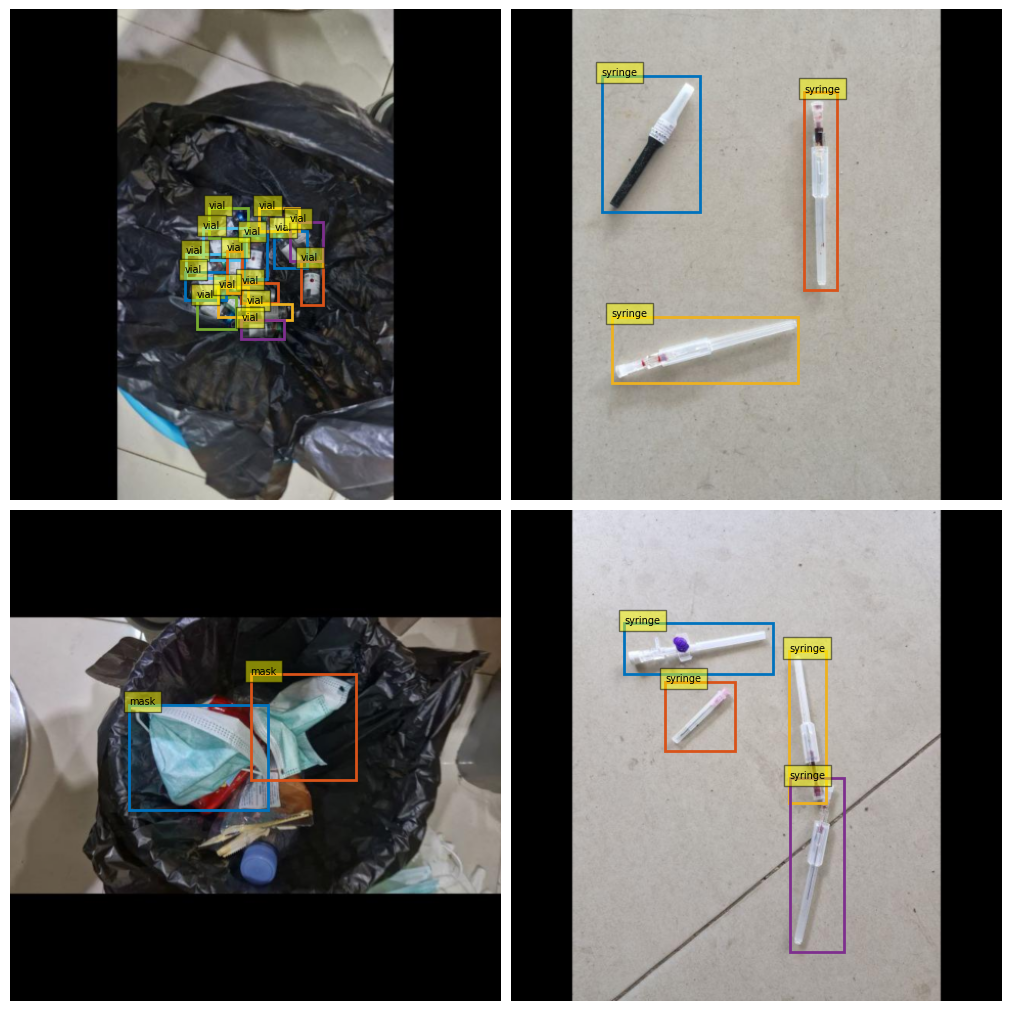

In [4]:
input_, (target) = next(iter(train_loader))
fig = plt.figure(figsize=(10, 10), constrained_layout=True)

for ix in range(4):
    t_cl = target[0][ix].cuda()
    t_bbox = target[1][ix].cuda()

    t_bbox = ops.box_convert(
        t_bbox*480, in_fmt='cxcywh', out_fmt='xyxy')

    im = revert_normalization(input_)[ix].\
        permute(1,2,0).cpu().clip(0,1)

    ax = fig.add_subplot(2, 2, ix+1)
    ax.imshow(im)
    plot_im_with_boxes(im, t_bbox, t_cl, ax=ax)
    ax.set_axis_off()

# The DETR Architecture

The DETR architecture is well posted on the diagram below of the original paper.

![](DETR_Architecture.png)

DETR presents four main components:

1. **CNN Backbone** extracts the image features and compacts the original image dimensions, similar to an embedding layer.
2. **Transformer's encoder** adds the PE information to the tokens and processes it through multiple layers, applying the self-attention mechanism and, hence, producing high-level features.
3. **Transformer's decoder** receives objects' queries as input and applies cross-attention between the queries and the encoder's feature map. Object queries are plain positional embedding information.
4. **FFN Heads** are composed of two heads despite the diagram above showing four. One head has 4 output units to predict the 4 box coordinates, and the other has 7 output units to predict the box classes. The FFN heads are just a sequence of linear layers and activation functions.

Now, we delve into each component's mechanism and illustrate them in the code. Here are some abbreviations to help us cope with the tensors' dimensions: B (Batch), C (Channels), H (Height), W (Width), T (Tokens), T' (squared root of T), and Q (Queries).

## 1. CNN Backbone

The backbone extracts image features and shrinks the original image dimensions, turning patches into embeddings. When using a standard ResNet-50, the dimension is shrunk by a factor of 32, which is equivalent to using a patch size of 32 on a vanilla ViT.

Consider an image input of (480, 480, 3), which translates to an input tensor with dimensions (1, 3, 480, 480). After passing the ResNet backbone, the input tensor becomes a coarse feature map of dimensions (1, 2048, 15, 15). The spatial information is compressed, but the depth dimension is enlarged. 

The large number of channels makes the computational load heavy for the transformer's encoder. This load is alleviated by applying a subsequent 1x1 convolutional layer to reduce the channel dimension from 2048 to 256. 
In this stage, the data tensor changed from (B, 3, H, W) to (B, C, T', T'). The number of channels of the embeddings (C = 256) is held through the entire transformer process, and this value is called the "model width".

See the code:

In [5]:
backbone = create_feature_extractor(
            torch.hub.load('pytorch/vision:v0.10.0',
                           'resnet50', pretrained=True),
            return_nodes={'layer4': 'layer4'}
)

d_model = 256
conv1x1 = nn.Conv2d(2048, d_model, kernel_size=1, stride=1)

x = torch.randn((1, 3, 480, 480))
embeddings = backbone(x)['layer4']
embeddings = conv1x1(embeddings)

print(x.shape, embeddings.shape)
# torch.Size([1, 3, 480, 480]) torch.Size([1, 256, 15, 15])

Using cache found in /home/starlord/.cache/torch/hub/pytorch_vision_v0.10.0
/home/starlord/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/starlord/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 3, 480, 480]) torch.Size([1, 256, 15, 15])


## 2. Transformer's encoder

Some actions are required before feeding the embeddings information to the encoder: 1) rearrange the image embeddings to a 1-D sequence length, and 2) add positional encoding information.

Rearranging the embeddings to a 1-D sequence length implies to flatten the tensor's height and width information, and to move the channel axis to the last dimension, such that the tensor dimensions change from (B, C, T', T') to (B, T, C).

While we're not using tokens in the same way as language models, they serve a similar purpose. The tokens' length here means the number of elements from the embeddings. In this example, the number of tokens is 15 * 15 = 225, which is the number of spatial units resulting from the backbone.

In [6]:
embeddings_old = embeddings.clone()
embeddings = rearrange(embeddings, 'b c h w -> b (h w) c')

print(embeddings_old.shape, embeddings.shape)
# torch.Size([1, 256, 15, 15]) torch.Size([1, 225, 256])

torch.Size([1, 256, 15, 15]) torch.Size([1, 225, 256])


The second required action is to add positional encoding. As the self-attention mechanism does not regard position information when crossing information between the embeddings, the PE helps to make spatial information relevant.

Some forms of adding PE into the embeddings exist, such as modeling the x and y patch coordinates into sine functions or even learning it along with the training. Both were tried on the DETR work. In our didactic example, we will also learn the PE parameters; the weights are initialized from a uniform distribution.

In [7]:
# the original implementation uses sine spatial PE
n_tokens = 225

inp_pe = nn.Parameter(
    torch.rand((1, n_tokens, d_model)),
    requires_grad=False)

embeddings += inp_pe

print(inp_pe.shape, embeddings.shape)
# torch.Size([1, 225, 256]) torch.Size([1, 225, 256])

torch.Size([1, 225, 256]) torch.Size([1, 225, 256])


After completing the required pre-steps, we instantiate the encoder itself. The tensor dimensions (B, T, C), in our case (1, 255, 256), are held constant throughout the transformer pass, including the decoder.

In [8]:
n_heads = 8
encoder_layer = nn.TransformerEncoderLayer(
    d_model=d_model, nhead=n_heads, dim_feedforward=4*d_model)

n_layers = 6
transformer_encoder = nn.TransformerEncoder(
    encoder_layer, num_layers=n_layers)

out_encoder = transformer_encoder(embeddings)

print(out_encoder.shape)
# torch.Size([1, 225, 256])

torch.Size([1, 225, 256])


/home/starlord/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


## 3. Transformer's decoder

A highlight concept introduced by DETR is object queries. The queries represent the asking for a box prediction; hence, Q object queries return Q number of box predictions. In a practical outlook, the queries are plain PE that feed the decoder. 

One caveat: when running B instances simultaneously, the Q information is replicated for the B length; the same happens with the encoder's PE. The queries tensor has the shape of (B, Q, C).

In [9]:
n_queries = 100

queries = nn.Parameter(
    torch.rand((1, n_queries, d_model)),
    requires_grad=False)

print(queries.shape, embeddings.shape)
# torch.Size([1, 100, 256]) torch.Size([1, 225, 256])

torch.Size([1, 100, 256]) torch.Size([1, 225, 256])


The decoder has a symmetric configuration with the encoder, i.e., the same number of heads and layers.

In [10]:
decoder_layer = nn.TransformerDecoderLayer(
    d_model=d_model,
    nhead=n_heads,
    dim_feedforward=4*d_model,
    batch_first=True)

transformer_decoder = nn.TransformerDecoder(
    decoder_layer, num_layers=n_layers)

out_decoder = transformer_decoder(queries, out_encoder)

print(out_decoder.shape, queries.shape, out_encoder.shape)
# torch.Size([1, 100, 256]) torch.Size([1, 100, 256]) torch.Size([1, 225, 256])

torch.Size([1, 100, 256]) torch.Size([1, 100, 256]) torch.Size([1, 225, 256])


## 4. FFN Heads

Finally, at the top of the architecture, two FFNs receive the decoder's outcomes as input. One FFN predicts the box classes, and the other predicts the box coordinates. In terms of dimensions, the decoder's outcome of shape (B, T, Q) is turned into (B, Q, 7) by the FFN in charge of the class predictions and into (B, Q, 4) by the FFN in charge of the coordinates predictions.

In [11]:
n_classes = 7

linear_class = nn.Linear(d_model, n_classes)
linear_bbox = nn.Linear(d_model, 4)

pred_classes = linear_class(out_decoder)
pred_bboxes = linear_bbox(out_decoder)

print(pred_classes.shape, pred_bboxes.shape)
# torch.Size([1, 100, 7]) torch.Size([1, 100, 4])

torch.Size([1, 100, 7]) torch.Size([1, 100, 4])


## Putting it all together
After joining all the components, we define the DETR architecture class.

In [12]:
def get_hook(outs, name):
    def hook(self, input, output):
        outs[name] = output
    return hook


class DETR(nn.Module):

    def __init__(
        self, d_model=256, n_classes=7, n_tokens=225,
        n_layers=6, n_heads=8, n_queries=100
    ):
        super().__init__()

        self.backbone = create_feature_extractor(
            torch.hub.load('pytorch/vision:v0.10.0',
                           'resnet50', pretrained=True),
            return_nodes={'layer4': 'layer4'}
        )

        self.conv1x1 = nn.Conv2d(
            2048, d_model, kernel_size=1, stride=1)

        self.pe_encoder = nn.Parameter(
            torch.rand((1, n_tokens, d_model)),
            requires_grad=True)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads,
            dim_feedforward=4*d_model, dropout=0.1)
        
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=n_layers)

        self.queries = nn.Parameter(
            torch.rand((1, n_queries, d_model)),
            requires_grad=True)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model, nhead=n_heads,
            dim_feedforward=4*d_model,
            batch_first=True, dropout=0.1)
        
        self.transformer_decoder = nn.TransformerDecoder(
            decoder_layer, num_layers=n_layers)

        self.linear_class = nn.Linear(d_model, n_classes)
        self.linear_bbox = nn.Linear(d_model, 4)

        # Add hooks to get intermediate outcomes
        self.decoder_outs = {}    
        for i, L in enumerate(self.transformer_decoder.layers):
            name = f'layer_{i}'
            L.register_forward_hook(
                get_hook(self.decoder_outs, name))
        
    
    def forward(self, x):
        tokens = self.backbone(x)['layer4']
        tokens = self.conv1x1(tokens)
        tokens = rearrange(tokens, 'b c h w -> b (h w) c')

        out_encoder = self.transformer_encoder(
            tokens + self.pe_encoder)
        
        out_decoder = self.transformer_decoder(
            self.queries.repeat(len(out_encoder), 1, 1),
            out_encoder)

        # Compute outcomes for all intermediate
        # decoder's layers
        outs = {}
        for n, o in self.decoder_outs.items():
            outs[n] = {
                'cl': self.linear_class(o),
                'bbox': self.linear_bbox(o)
            }
        
        return outs

In [13]:
detr = DETR(
    d_model=256, n_classes=7, n_tokens=225, 
    n_layers=6, n_heads=8, n_queries=100
)

x = torch.randn((1, 3, 480, 480))
outs = detr(x)
pred_cl, pred_boxes = outs['layer_5'].values()

print(pred_cl.shape, pred_boxes.shape)
# torch.Size([1, 100, 7]) torch.Size([1, 100, 4])

Using cache found in /home/starlord/.cache/torch/hub/pytorch_vision_v0.10.0
/home/starlord/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/starlord/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 100, 7]) torch.Size([1, 100, 4])


/home/starlord/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


The code above has forward hooks due to auxiliary losses, which will be explained in the next session.

# Training

Our next step is to understand the particularities of the DETR training. We break this session into three parts: 1) the set prediction problem, 2) the compound loss function, and 3) auxiliary losses.

## The Set Prediction Problem 

An innovative approach in the DETR project was framing the detection task as a set prediction task. This paradigm involves matching elements between the set of predictions and the set of labels, such that the sum of the errors between the matches is minimized rather than the sum of individual box errors. The optimal set of matches is computed by a bipartite matching algorithm called the Hungarian algorithm.

The Hungarian algorithm operates on a cost matrix that stores the dissimilarity between all elements of both sets. It's important to note that not every element matches its best correspondence, as the bipartite algorithm optimizes the sum of the matches.

The cost matrix has dimensions (Q, len(target)), in which each cell (i, j) stores a dissimilarity metric of the pair (the prediction "i" and the label "j"). The dissimilarity metric is the weight summation of the generalized intersection over union (GIoU) over the boxes, L1-norm between the box coordinates (xy, xy), and the L1-norm between the box class probabilities. The respective weights are 1, 5, and 2. The Hungarian algorithm is applied with the method linear_sum_assignment.

A critical point during training is dealing with the varied number of boxes in each COCO image. Among the COCO images, the number of boxes varies between 1 and 63 boxes. On the other hand, DETR assumes a fixed number of predictions, 100, which is the query size Q. This problem is solved by assigning an additional "empty class" to all predictions without a correspondent match.

See the code below:

In [14]:
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)

input_, (tgt_cl, tgt_bbox) = next(iter(train_loader))

outs = detr(input_)
out_cl, out_bbox = outs['layer_5'].values()

train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)

input_, (tgt_cl, tgt_bbox) = next(iter(train_loader))

outs = detr(input_)
out_cl, out_bbox = outs['layer_5'].values()

out_bbox = out_bbox.sigmoid()

o_bbox = out_bbox[0]
t_bbox = tgt_bbox[0]
o_cl = out_cl[0]
t_cl = tgt_cl[0]
    
o_probs = o_cl.softmax(dim=-1)

# Negative sign here because we want the maximum magnitude
C_classes = -o_probs[..., t_cl]

# Positive sign here because we want to shrink the l1-norm
C_boxes = torch.cdist(o_bbox, t_bbox, p=1)

# Negative sign here because we want the maximum magnitude
C_giou = -ops.generalized_box_iou(
    ops.box_convert(o_bbox, in_fmt='cxcywh', out_fmt='xyxy'),
    ops.box_convert(t_bbox, in_fmt='cxcywh', out_fmt='xyxy')
)

C_total = 1*C_classes + 5*C_boxes + 2*C_giou

# Convert the tensor to numpy array
C_total = C_total.cpu().detach().numpy()

# Find the optimum pairs that produces the minimum summation.
# The method returns the pair indices
o_ixs, t_ixs = linear_sum_assignment(C_total)

print(t_bbox.shape, o_bbox.shape, C_total.shape)
out_bbox = out_bbox.sigmoid()

o_bbox = out_bbox[0]
t_bbox = tgt_bbox[0]
o_cl = out_cl[0]
t_cl = tgt_cl[0]
    
o_probs = o_cl.softmax(dim=-1)

# Negative sign here because we want the maximum magnitude
C_classes = -o_probs[..., t_cl]

# Positive sign here because we want to shrink the l1-norm
C_boxes = torch.cdist(o_bbox, t_bbox, p=1)

# Negative sign here because we want the maximum magnitude
C_giou = -ops.generalized_box_iou(
    ops.box_convert(o_bbox, in_fmt='cxcywh', out_fmt='xyxy'),
    ops.box_convert(t_bbox, in_fmt='cxcywh', out_fmt='xyxy')
)

C_total = 1*C_classes + 5*C_boxes + 2*C_giou

# Convert the tensor to numpy array
C_total = C_total.cpu().detach().numpy()

# Find the optimum pairs that produces the minimum summation.
# The method returns the pair indices
o_ixs, t_ixs = linear_sum_assignment(C_total)

print(t_bbox.shape, o_bbox.shape, C_total.shape)
# torch.Size([26, 4]) torch.Size([100, 4]) (100, 26)

torch.Size([15, 4]) torch.Size([100, 4]) (100, 15)
torch.Size([15, 4]) torch.Size([100, 4]) (100, 15)


## The Loss Function

The loss computation is close to the dissimilarity metric previously computed for the Hungarian algorithm, but adjustments exist. For example, the standard cross-entropy between the class distributions is adopted instead of using the bare probability values for the class component. Besides, all predictions that did not match any target are assigned as empty classes, and a cross-entropy loss is computed apart for them and added into the final loss summation. The complete training code is shown below:

In [15]:
# Transform indices to tensors
o_ixs = torch.IntTensor(o_ixs)
t_ixs = torch.IntTensor(t_ixs)

# Reorder o_ixs to naturally align with target_cl length, such
# the pairs are {(o_ixs[0], t[0]), {o_ixs[1], t[1]}, ...}
o_ixs = o_ixs[t_ixs.argsort()]

# Average over the number of boxes, not the number of coordinates
num_boxes = len(t_bbox)
loss_bbox = F.l1_loss(
    o_bbox[o_ixs], t_bbox, reduce='sum') / num_boxes

# Vectorize the operation
target_gIoU = ops.generalized_box_iou(
    ops.box_convert(o_bbox[o_ixs], in_fmt='cxcywh', out_fmt='xyxy'),
    ops.box_convert(t_bbox, in_fmt='cxcywh', out_fmt='xyxy')
)
# Get only the matrix diagonal that contains the bipartite pairs
# and transform gIoU into a loss
loss_giou = 1 - torch.diag(target_gIoU).mean()

# Assign empty class for the outside predictions
queries_classes_label = torch.full(o_probs.shape[:1], 6)
queries_classes_label[o_ixs] = t_cl
loss_class = F.cross_entropy(o_cl, queries_classes_label)

loss_total = 1*loss_class + 5*loss_bbox + 2*loss_giou
print(loss_total)
# tensor(5.5788, grad_fn=<AddBackward0>)

tensor(4.4758, grad_fn=<AddBackward0>)


/home/starlord/.local/lib/python3.10/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


## Auxiliary losses

Now that we know how to compute loss, an important detail to speed up convergence and stabilize training is auxiliary losses. In this case, auxiliary losses only applies the same loss function to the outcome of all the intermediate layers of the transformer's decoder.
 
To do so, all the intermediate features are obtained with the get_hook function declared in the DETR class snippet. Then, the same FFN heads are used to predict box coordinates and classes for each decoder layer. It becomes clearer after checking the forward method of class DETR defined above.

## Putting it all together

We join all the pieces above and make it run over the short train set of 50 samples. To speed up the training, we do not train the backbone together. 

Beforehand, I create a specific function to compute the sample loss.

In [16]:
def compute_sample_loss(
    o_bbox, t_bbox, o_cl, t_cl, n_queries=100):
    
    # If  the example has none box, we just feed it with empty classes.
    if len(t_cl) > 0:
        
        t_bbox = t_bbox.cuda()
        t_cl = t_cl.cuda()

        o_probs = o_cl.softmax(dim=-1)

        # Negative sign here because we want the maximum magnitude
        C_classes = -o_probs[..., t_cl]
        
        # Positive sign here because we want to shrink the l1-norm
        C_boxes = torch.cdist(o_bbox, t_bbox, p=1)
        
        # Negative sign here because we want the maximum magnitude
        C_giou = -ops.generalized_box_iou(
            ops.box_convert(o_bbox, in_fmt='cxcywh', out_fmt='xyxy'),
            ops.box_convert(t_bbox, in_fmt='cxcywh', out_fmt='xyxy')
        )
        
        C_total = 1*C_classes + 5*C_boxes + 2*C_giou
        
        # Convert the tensor to numpy array
        C_total = C_total.cpu().detach().numpy()
        
        # Find the optimum pairs that produces the minimum summation.
        # the method returns the pair indices
        o_ixs, t_ixs = linear_sum_assignment(C_total)            
        
        # Transform indices to tensors
        o_ixs = torch.IntTensor(o_ixs)
        t_ixs = torch.IntTensor(t_ixs)
        
        # Reorder o_ixs to naturally align with target_cl length, such
        # the pairs are {(o_ixs[0], t[0]), {o_ixs[1], t[1]}, ...}
        o_ixs = o_ixs[t_ixs.argsort()]
        
        # Average over the number of boxes, not the number of coordinates
        num_boxes = len(t_bbox)
        loss_bbox = F.l1_loss(
            o_bbox[o_ixs], t_bbox, reduce='sum') / num_boxes
        
        # vectorize the operation
        target_gIoU = ops.generalized_box_iou(
            ops.box_convert(o_bbox[o_ixs], in_fmt='cxcywh', out_fmt='xyxy'),
            ops.box_convert(t_bbox, in_fmt='cxcywh', out_fmt='xyxy')
        )
        # get only the matrix diagonal that contains the bipartite pairs
        # and transform gIoU into a loss
        loss_giou = 1 - torch.diag(target_gIoU).mean()
        
        # assign empty class for the outside predictions
        queries_classes_label = torch.full(o_probs.shape[:1], 6).cuda()
        queries_classes_label[o_ixs] = t_cl
        loss_class = F.cross_entropy(o_cl, queries_classes_label)

    else:
        queries_classes_label = torch.full((n_queries,), 6).cuda()
        loss_class = F.cross_entropy(o_cl, queries_classes_label)
        loss_bbox = loss_giou = torch.tensor(0)
    
    return loss_class, loss_bbox, loss_giou

Then, we instantiate the model and set the optimizer.

In [17]:
# Ensure saving directory exists
![ ! -d ckpts-tiny ] && mkdir ckpts-tiny

detr = DETR(d_model=256, n_classes=7, n_tokens=225, 
            n_layers=6, n_heads=8, n_queries=100)
detr.cuda()

backbone_params = [
    p for n, p in detr.named_parameters() if 'backbone.' in n]

for p in detr.backbone.parameters():
    p.requires_grad = False
    
transformer_params = [
    p for n, p in detr.named_parameters() if 'backbone.' not in n]

optimizer = AdamW([
    {'params': transformer_params, 'lr': 1e-5},
], weight_decay=1e-4)

nparams = sum([p.nelement() for p in detr.parameters()]) / 1e6
print(f'DETR params: {nparams:.1f}M')
# DETR params: 35.2M

Using cache found in /home/starlord/.cache/torch/hub/pytorch_vision_v0.10.0
/home/starlord/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/starlord/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DETR params: 35.2M


/home/starlord/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In the original DETR work, they trained 300 epochs with a batch size of 64. To get a glimpse of this network capacity, we will do a shorter experiment. We ran 157 epochs with a batch size of 16. The reduced batch size is due to GPU constraints.

In the training code,the backbone parameters are trained together with the transformer parameters. We also adapt the code to run and evaluate based on epochs; one COCO epoch equals 381 iterations of batch size 16.

Our current setup of resized inputs with a size of 480px requires 16GB of GPU VRAM to fit the 16 samples simultaneously.

The training loop based on epochs:

In [18]:
torch.set_grad_enabled(True)
detr.train()

batch_size = 16
train_loader = DataLoader(
    train_ds, batch_size=batch_size,
    shuffle=True, collate_fn=collate_fn)

niters = 60000
print_every_n = 1000
save_every_n = 10000
losses = []

hist = []
iters = 1

while iters <= niters:
    
    for input_, (tgt_cl, tgt_bbox) in train_loader:
        input_ = input_.cuda()
        
        outs = detr(input_)
        
        loss = torch.Tensor([0]).cuda()
        for name, out in outs.items(): 
            
            out['bbox'] = out['bbox'].sigmoid()
            
            for o_bbox, t_bbox, o_cl, t_cl in zip(
                out['bbox'], tgt_bbox, out['cl'], tgt_cl):
        
                loss_class, loss_bbox, loss_giou = compute_sample_loss(
                    o_bbox, t_bbox, o_cl, t_cl)
                
                sample_loss = 1*loss_class + 5*loss_bbox + 2*loss_giou
                
                loss += sample_loss / batch_size / len(outs)
            
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        
        # clip gradient norms
        nn.utils.clip_grad_norm_(detr.parameters(), .1)
        optimizer.step()
        
        losses.append(loss.item())

        if iters % print_every_n == 0:
            loss_avg = np.mean(losses[-10:])
            print_text = f'iters: {iters},\tloss: {loss_avg:.4f}'
            print(print_text)
            print(f'loss_class: {loss_class.item():.4f}\tloss_bbox: {loss_bbox.item():.4f}\tloss_giou: {loss_giou.item():.4f}\t')
            
            hist.append(loss_avg)
            losses = []

        if iters % save_every_n == 0 and iters > 0:
            str_iters = str(iters)
            str_iters = '0'*(6-len(str_iters)) + str_iters
            torch.save(detr.state_dict(), f'ckpts-tiny/model_it{str_iters}.pt')
            np.save(f'ckpts-tiny/hist_it{str_iters}.npy', hist)

        iters += 1
        if iters > niters:
            break

/home/starlord/.local/lib/python3.10/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


iters: 1000,	loss: 1.3030
loss_class: 0.2554	loss_bbox: 0.0132	loss_giou: 0.5292	
iters: 2000,	loss: 1.2694
loss_class: 0.0280	loss_bbox: 0.0079	loss_giou: 0.7917	
iters: 3000,	loss: 1.1703
loss_class: 0.1629	loss_bbox: 0.0094	loss_giou: 0.3695	
iters: 4000,	loss: 1.1538
loss_class: 0.2553	loss_bbox: 0.0115	loss_giou: 0.4467	
iters: 5000,	loss: 1.1280
loss_class: 0.0788	loss_bbox: 0.0243	loss_giou: 0.2020	
iters: 6000,	loss: 1.0991
loss_class: 0.2387	loss_bbox: 0.0079	loss_giou: 0.4476	
iters: 7000,	loss: 1.0556
loss_class: 0.1852	loss_bbox: 0.0074	loss_giou: 0.3708	
iters: 8000,	loss: 1.0557
loss_class: 0.0140	loss_bbox: 0.0078	loss_giou: 0.3759	
iters: 9000,	loss: 1.0258
loss_class: 0.1131	loss_bbox: 0.0100	loss_giou: 0.3317	
iters: 10000,	loss: 0.9800
loss_class: 0.2088	loss_bbox: 0.0075	loss_giou: 0.6507	
iters: 11000,	loss: 0.9799
loss_class: 0.1478	loss_bbox: 0.0136	loss_giou: 0.4543	
iters: 12000,	loss: 0.9191
loss_class: 0.0076	loss_bbox: 0.0051	loss_giou: 0.4015	
iters: 13000,

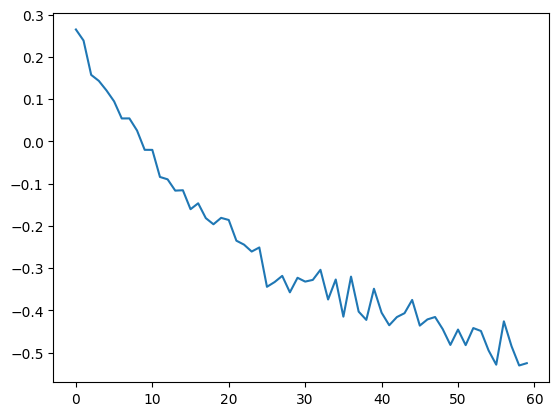

In [23]:
plt.plot(np.log(hist))

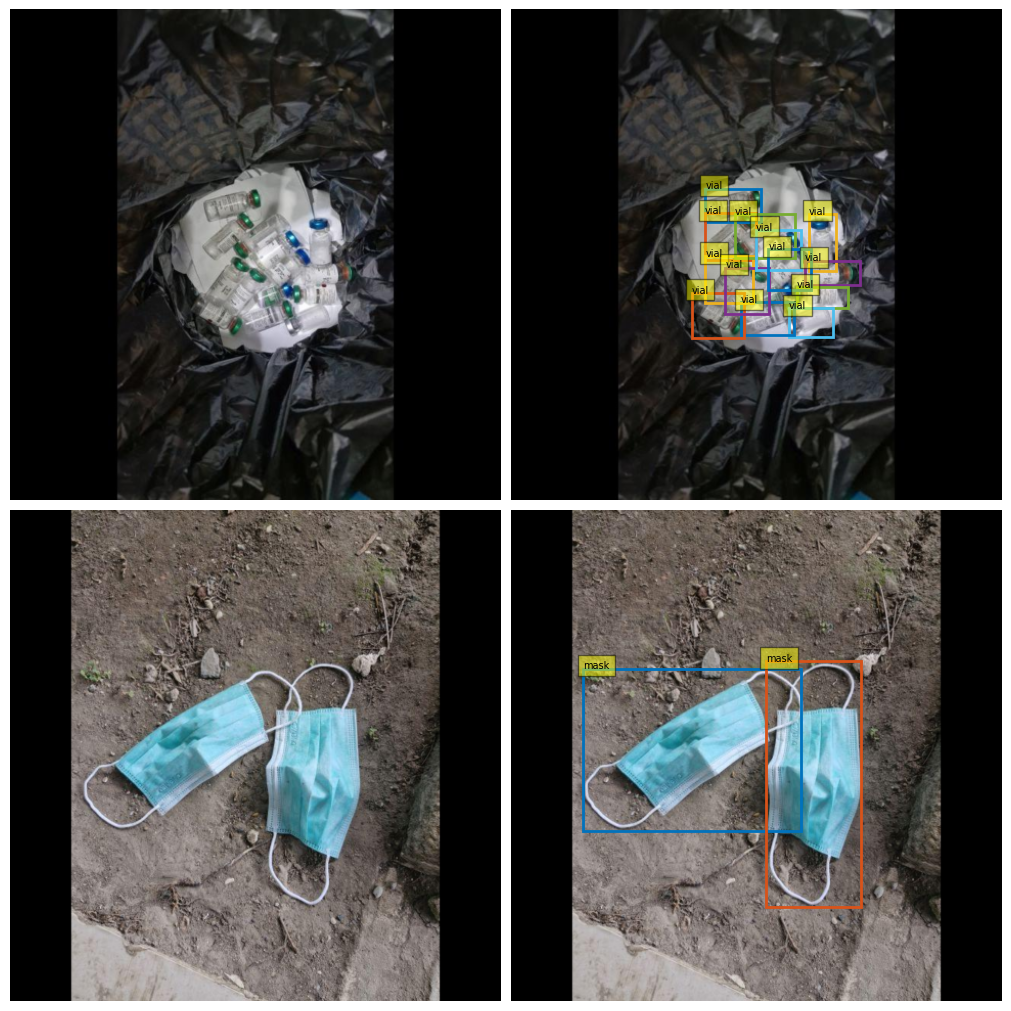

In [37]:
# Load best checkpoint
states = torch.load('ckpts-tiny/model_it060000.pt')
detr.load_state_dict(states)

# Set evaluation mode
torch.set_grad_enabled(False)
detr.eval()

# Create dataloader
test_loader = DataLoader(
    test_ds, batch_size=2, shuffle=True, collate_fn=collate_fn)

# Get sample batch
input_, (tgt_cl, tgt_bbox) = next(iter(eval_loader))[:2]

# Run inference
out_cl, out_bbox = detr(input_.cuda())['layer_5'].values()
out_bbox = out_bbox.sigmoid().cpu()
out_cl = out_cl.cpu()

# Calculate loss
total_loss = 0
detected_objects = []

for ix in range(len(out_bbox)):
    # Process predictions
    o_cl = out_cl[ix]
    t_cl = tgt_cl[ix]
    o_bbox = out_bbox[ix]
    t_bbox = tgt_bbox[ix]
    
    # Get predictions
    o_probs = o_cl.softmax(dim=-1)
    o_bbox_px = ops.box_convert(o_bbox*480, 'cxcywh', 'xyxy')
    
    # Filter out background predictions (class 0)
    keep = o_probs.argmax(-1) != 0
    
    # Store detected objects with confidence
    for prob, bbox in zip(o_probs[keep], o_bbox_px[keep]):
        class_idx = prob.argmax().item()
        confidence = prob[class_idx].item() * 100
        detected_objects.append({
            'class': CLASSES[class_idx],
            'confidence': confidence
        })

fig, axs = plt.subplots(2, 2, figsize=(10, 10), constrained_layout=True)
[a.set_axis_off() for a in axs.ravel()]
    
for ix in range(len(out_bbox)):
    o_cl = out_cl[ix]
    t_cl = tgt_cl[ix]
    o_bbox = out_bbox[ix]
    t_bbox = tgt_bbox[ix]
    
    o_probs = o_cl.softmax(dim=-1)
    o_bbox = ops.box_convert(o_bbox*480, in_fmt='cxcywh', out_fmt='xyxy')
    t_bbox = ops.box_convert(t_bbox*480, in_fmt='cxcywh', out_fmt='xyxy')
    
    im = revert_normalization(input_)[ix].permute(1,2,0).cpu().clip(0,1)

    o_keep = o_probs.argmax(-1) != 6

    axs[ix, 0].imshow(im)
    plot_im_with_boxes(im, o_bbox[o_keep], o_probs[o_keep], ax=axs[ix, 0])
    axs[ix, 1].imshow(im)
    plot_im_with_boxes(im, t_bbox, t_cl, ax=axs[ix, 1])

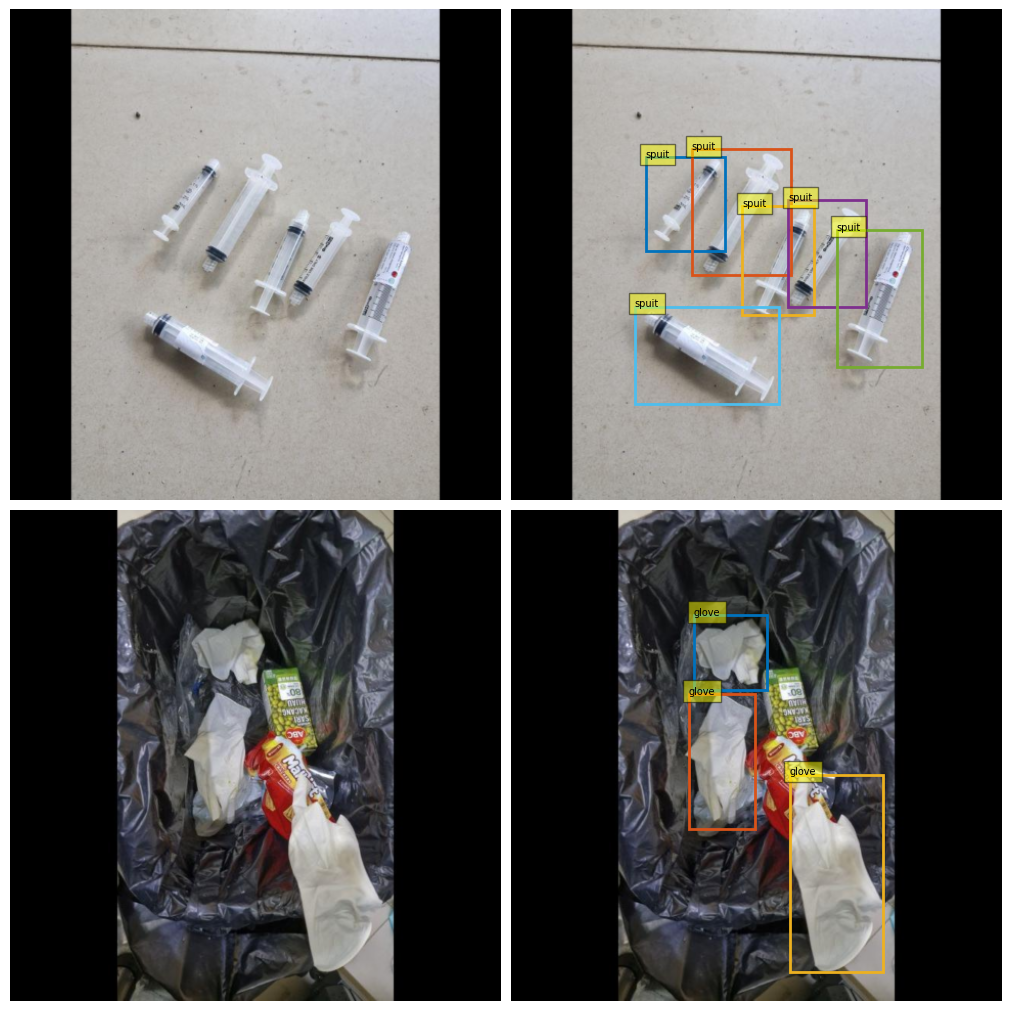

In [36]:
# Load best checkpoint
states = torch.load('ckpts-tiny/model_it060000.pt')
detr.load_state_dict(states)

# Set evaluation mode
torch.set_grad_enabled(False)
detr.eval()

# Create dataloader
test_loader = DataLoader(
    test_ds, batch_size=2, shuffle=True, collate_fn=collate_fn)

# Get sample batch
input_, (tgt_cl, tgt_bbox) = next(iter(eval_loader))[:2]

# Run inference
out_cl, out_bbox = detr(input_.cuda())['layer_5'].values()
out_bbox = out_bbox.sigmoid().cpu()
out_cl = out_cl.cpu()

# Calculate loss
total_loss = 0
detected_objects = []

for ix in range(len(out_bbox)):
    # Process predictions
    o_cl = out_cl[ix]
    t_cl = tgt_cl[ix]
    o_bbox = out_bbox[ix]
    t_bbox = tgt_bbox[ix]
    
    # Get predictions
    o_probs = o_cl.softmax(dim=-1)
    o_bbox_px = ops.box_convert(o_bbox*480, 'cxcywh', 'xyxy')
    
    # Filter out background predictions (class 0)
    keep = o_probs.argmax(-1) != 0
    
    # Store detected objects with confidence
    for prob, bbox in zip(o_probs[keep], o_bbox_px[keep]):
        class_idx = prob.argmax().item()
        confidence = prob[class_idx].item() * 100
        detected_objects.append({
            'class': CLASSES[class_idx],
            'confidence': confidence
        })

fig, axs = plt.subplots(2, 2, figsize=(10, 10), constrained_layout=True)
[a.set_axis_off() for a in axs.ravel()]
    
for ix in range(len(out_bbox)):
    o_cl = out_cl[ix]
    t_cl = tgt_cl[ix]
    o_bbox = out_bbox[ix]
    t_bbox = tgt_bbox[ix]
    
    o_probs = o_cl.softmax(dim=-1)
    o_bbox = ops.box_convert(o_bbox*480, in_fmt='cxcywh', out_fmt='xyxy')
    t_bbox = ops.box_convert(t_bbox*480, in_fmt='cxcywh', out_fmt='xyxy')
    
    im = revert_normalization(input_)[ix].permute(1,2,0).cpu().clip(0,1)

    o_keep = o_probs.argmax(-1) != 6

    axs[ix, 0].imshow(im)
    plot_im_with_boxes(im, o_bbox[o_keep], o_probs[o_keep], ax=axs[ix, 0])
    axs[ix, 1].imshow(im)
    plot_im_with_boxes(im, t_bbox, t_cl, ax=axs[ix, 1])

# Takeaways

* DETR was one of the pioneers of transformer-based work for computer vision tasks that presented a competitive result. It fostered more investigation of this architecture in computer vision, eventually becoming a state-of-the-art paradigm.
* DETR introduced new elements for deep learning projects like object queries and the set prediction problem, which were fundamental to other works like Mask2Former and OneFormer, which achieve state-of-the-art results.
* DETR can take a very long training time to start presenting fair results.

## References

Toledo, R. (2024, May 21). Understanding and Coding DETR (DEtection TRansfomer). Medium. https://medium.com/@rafaeltol/understanding-and-coding-detr-detection-transfomer-80e4c206fbc8